Task 2 Part 1: Generating Images using a CVAE on the CIFAR 10 Dataset

Some of the Images being generated are far too blurry even after playing with Hyoerparameters and adjusting the model.

In [17]:
from IPython import display
import glob
import imageio
import matplotlib.pyplot as plt
import numpy as np
import PIL
import tensorflow as tf
#import tensorflow_probability as tfp
import time


In [20]:
(train_images, _), (test_images, _) = tf.keras.datasets.cifar10.load_data()

def preprocess_images(images):
  images = images.reshape((images.shape[0], 32, 32, 3)) / 255.
  return np.where(images > .5, 1.0, 0.0).astype('float32')

train_images = preprocess_images(train_images)
test_images = preprocess_images(test_images)

train_size = 60000
batch_size = 32
test_size = 10000

train_dataset = (tf.data.Dataset.from_tensor_slices(train_images)
                 .shuffle(train_size).batch(batch_size))
test_dataset = (tf.data.Dataset.from_tensor_slices(test_images)
                .shuffle(test_size).batch(batch_size))


In [85]:
class CVAE(tf.keras.Model):
  """Convolutional variational autoencoder."""

  def __init__(self, latent_dim):
        super(CVAE, self).__init__()
        self.latent_dim = latent_dim
        self.encoder = tf.keras.Sequential(
            [tf.keras.layers.InputLayer(input_shape=(32, 32, 3)),
                tf.keras.layers.Conv2D(
                  filters=32, kernel_size=3, strides=(2, 2), 
                  activation='relu'),
                tf.keras.layers.BatchNormalization(),
                tf.keras.layers.Conv2D(
                  filters=64,kernel_size=3,strides=(2, 2), 
                  activation='relu'),
                tf.keras.layers.BatchNormalization(),
                tf.keras.layers.Conv2D(
                  filters=128, kernel_size=3,strides=(2, 2), 
                  activation='relu'),
                tf.keras.layers.BatchNormalization(),
                tf.keras.layers.Flatten(),
                tf.keras.layers.Dense(latent_dim + latent_dim),]
        )

        self.decoder = tf.keras.Sequential(
            [tf.keras.layers.InputLayer(input_shape=(latent_dim,)),
            tf.keras.layers.Dense(units=4*4*128, activation=tf.nn.relu),
            tf.keras.layers.Reshape(target_shape=(4, 4, 128)),
            tf.keras.layers.Conv2DTranspose(
              filters=128, kernel_size=3, strides=2, padding='same', 
              activation='relu'),
            tf.keras.layers.BatchNormalization(),
            tf.keras.layers.Conv2DTranspose(
              filters=64, kernel_size=3, strides=2, padding='same', 
              activation='relu'),
            tf.keras.layers.BatchNormalization(),
            tf.keras.layers.Conv2DTranspose(
              filters=32, kernel_size=3, strides=2,padding='same', 
              activation='relu'),
            tf.keras.layers.BatchNormalization(),
            tf.keras.layers.Conv2DTranspose(
              filters=3, kernel_size=3, strides=1, padding='same'),]
        )

  @tf.function
  def sample(self, eps=None):
    if eps is None:
      eps = tf.random.normal(shape=(100, self.latent_dim))
    return self.decode(eps, apply_sigmoid=True)

  def encode(self, x):
    mean, logvar = tf.split(self.encoder(x), num_or_size_splits=2, axis=1)
    return mean, logvar

  def reparameterize(self, mean, logvar):
    eps = tf.random.normal(shape=mean.shape)
    return eps * tf.exp(logvar * .5) + mean

  def decode(self, z, apply_sigmoid=False):
    logits = self.decoder(z)
    if apply_sigmoid:
      probs = tf.sigmoid(logits)
      return probs
    return logits


In [101]:
optimizer = tf.keras.optimizers.Adam(1e-4)


def log_normal_pdf(sample, mean, logvar, raxis=1):
  log2pi = tf.math.log(2. * np.pi)
  return tf.reduce_sum(
      -.5 * ((sample - mean) ** 2. * tf.exp(-logvar) + logvar + log2pi),
      axis=raxis)


def compute_loss(model, x):
  mean, logvar = model.encode(x)
  z = model.reparameterize(mean, logvar)
  x_logit = model.decode(z)
  cross_ent = tf.nn.sigmoid_cross_entropy_with_logits(logits=x_logit, labels=x)
  logpx_z = -tf.reduce_sum(cross_ent, axis=[1, 2, 3])
  logpz = log_normal_pdf(z, 0., 0.)
  logqz_x = log_normal_pdf(z, mean, logvar)
  return -tf.reduce_mean(logpx_z + logpz - logqz_x)


@tf.function
def train_step(model, x, optimizer):
  """Executes one training step and returns the loss.

  This function computes the loss and gradients, and uses the latter to
  update the model's parameters.
  """
  with tf.GradientTape() as tape:
    loss = compute_loss(model, x)
  gradients = tape.gradient(loss, model.trainable_variables)
  optimizer.apply_gradients(zip(gradients, model.trainable_variables))


In [102]:
epochs = 10
# set the dimensionality of the latent space to a plane for visualization later
latent_dim = 128
num_examples_to_generate = 16

# keeping the random vector constant for generation (prediction) so
# it will be easier to see the improvement.
random_vector_for_generation = tf.random.normal(
    shape=[num_examples_to_generate, latent_dim])
model = CVAE(latent_dim)


In [103]:
def generate_and_save_images(model, epoch, test_sample):
  mean, logvar = model.encode(test_sample)
  z = model.reparameterize(mean, logvar)
  predictions = model.sample(z)
  fig = plt.figure(figsize=(4, 4))

  for i in range(predictions.shape[0]):
    plt.subplot(4, 4, i + 1)
    plt.imshow(predictions[i, :, :])
    plt.axis('off')

  # tight_layout minimizes the overlap between 2 sub-plots
  plt.savefig('image_at_epoch_{:04d}.png'.format(epoch))
  plt.show()


In [104]:
# Pick a sample of the test set for generating output images
assert batch_size >= num_examples_to_generate
for test_batch in test_dataset.take(1):
  test_sample = test_batch[0:num_examples_to_generate, :, :, :]


2024-03-15 11:46:03.291057: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Epoch: 10, Test set ELBO: -674.1355590820312, time elapse for current epoch: 112.04448580741882


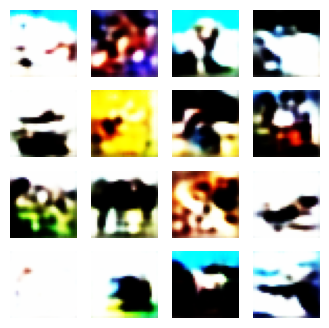

In [107]:
generate_and_save_images(model, 0, test_sample)

for epoch in range(1, epochs + 1):
  start_time = time.time()
  for train_x in train_dataset:
    train_step(model, train_x, optimizer)
  end_time = time.time()

  loss = tf.keras.metrics.Mean()
  for test_x in test_dataset:
    loss(compute_loss(model, test_x))
  elbo = -loss.result()
  display.clear_output(wait=True)
  print('Epoch: {}, Test set ELBO: {}, time elapse for current epoch: {}'
        .format(epoch, elbo, end_time - start_time))
  generate_and_save_images(model, epoch, test_sample)
